In [1]:
# Loading libraries
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations

from ipywidgets import interactive, HBox, VBox, Layout # Library to create interactive widgets
import ipywidgets as widgets               # Library to create interactive widgets

# importing of necessary libraries including cellpose and skimage
from cellpose import plot, models           # Module from cellpose
from skimage.morphology import remove_small_objects # Module from skimage

# Image Characteristics

In [2]:
img_0 = []
for i in range(6):
    figName = './NoDrug/rep1_FOV' + str(i+1) + '.tif'
    img = imread(str(figName))
    img_0.append(img)


In [5]:
img_0[0].shape

(21, 650, 650, 3)

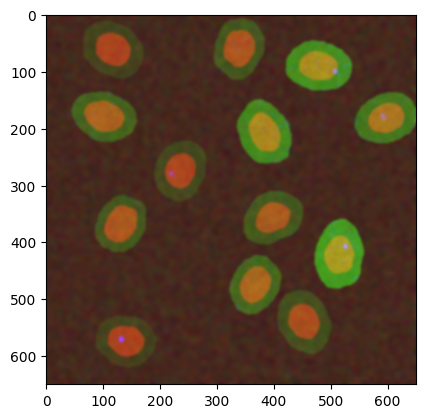

In [6]:
plt.imshow(img_0[0][0])

In [15]:
# FISH visualizer

def FISH_viewer(time=1):
    '''
    This function is intended to display an image from an array of images (specifically, video: img_int8). 
         img_int8 is a numpy array with dimension [T,Y,X,C].
    drop_channel : str with options 'Ch_0', 'Ch_1', 'Ch_2', 'All'
    time: int with range 0 to the number of frames in video.
    '''
    fig, axes = plt.subplots(1,3,dpi=120,figsize=(8,3))
    img = img_0[0]
    Red = img[time,:,:,0]
    im1 = axes[0].imshow(Red,cmap='Reds_r')
    Green = img[time,:,:,1]
    im2 = axes[1].imshow(Green,cmap='Greens_r')
    Blue = img[time,:,:,2]
    im3 =  axes[2].imshow(Blue,cmap='Blues_r')
    axes[0].axis('off')
    axes[1].axis('off')
    axes[2].axis('off')
    plt.show()

# Defining an interactive plot
# %pip install ipywidgets
# from ipywidgets import interactive, HBox, VBox, Layout
# import ipywidgets as widgets

interactive_plot = interactive(FISH_viewer, time = widgets.IntSlider(min=0,max=img.shape[0]-1,step=1,value=0,description='time frame'))       
# interactive_plot = interactive(FISH_viewer, img = widgets.Dropdown(options = {'Delta N':img_0[0], 'Delta E': img_0[1]}))
# time slider parameters
# Creates the controls
controls = HBox(interactive_plot.children[:-1], layout = Layout(flex_flow='row wrap'))
# Creates the outputs
output = interactive_plot.children[-1]

# Display the controls and output as an interactive widget
display(VBox([controls, output]))

In [8]:
# load the videos from the dataset as 3 channels, with each channel having 21 frames. These frames represent time.
# For the red channel, we want to set a threshold to remove noise in the image red: set a thrshold to remove noise to create the mask (binary) -> number of viable cells
# nucleus size (area of 1s/2s/.../ns)

# green: cell size (mask, binary)
# average of intensity of each cell -> protein concentration of each cell (multiply mask of red)

# blue: (Mask)1.transcription sites (set intensity threshold to capture brightest), 2.mRNA (the dimmer dots)
# transcription sites found by subset of time frame (linspace) or maximum throughout all time
# blue: number of mRNA in nucleus (red True/1 multiply blue mask2(binary with threshold))
# number of mRNA in cytoplasm (green subtract red True/1 multiply blue mask1/ total - number in nucleus)


# Masking

## Masking The Nuclei and Cytoplasms

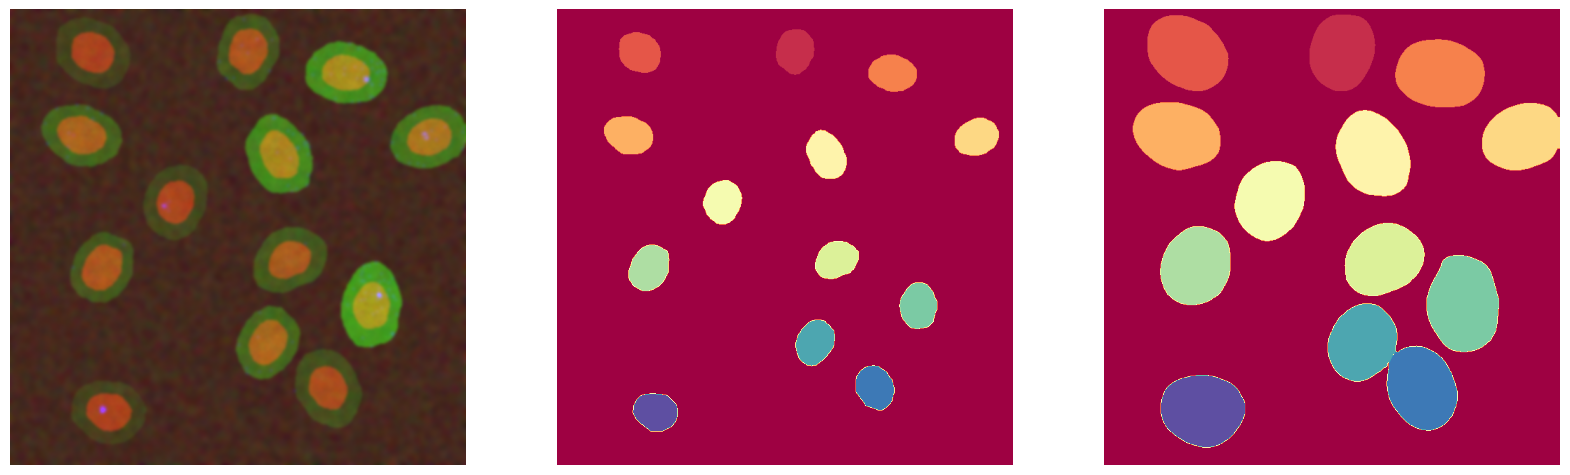

Number of nuclei: 13
Number of cytoplasms: 13


In [11]:
# Load the image
img = img_0[0] # the [0] is to select the first image in the list
img_nuc = img[0,:,:,0] # selecting the first channel of the image as the nuclei channel

# Run Cellpose to segment the nuclei
model = models.Cellpose(model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc  = model.eval(img_nuc, diameter=100, channels=[0,1])[0] # diameter is the expected diameter of the nuclei
masks_nuc = remove_small_objects(masks_nuc, min_size=50) # remove small objects from the mask

# Run Cellpose to segment the cytoplasm
img_cyto = img[0,:,:,1] # selecting the second channel of the image as the cytoplasm channel
model = models.Cellpose(model_type='cyto') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto, flows, styles, diams = model.eval(img_cyto, diameter=200, channels=[0,2]) # diameter is the expected diameter of the cytoplasm

# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1, 3, figsize=(20, 7))
ax[0].imshow(img_0[0][0,:,:,:], cmap='Greys_r')
im = ax[1].imshow(masks_nuc,cmap='Spectral')
# fig.colorbar(im, orientation='vertical')
im2 = ax[2].imshow(masks_cyto,cmap='Spectral')
# fig.colorbar(im2, orientation='vertical')

# This Python code is turning off the axis lines and labels for the first three subplots in a Matplotlib figure and then displaying the figure.
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

# Counting the number of nuclei and cytoplasms
print(f'Number of nuclei: {len(np.unique(masks_nuc))-1}')
print(f'Number of cytoplasms: {len(np.unique(masks_cyto))-1}')

In [12]:

nucleus_indices = np.zeros(np.max(masks_cyto)+1) # array to store the index of the nucleus in the masks_nuc array
for i in range(1,np.max(masks_nuc)+1): # loop through each nucleus
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int) # find the position of the nucleus
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i # store the index of the nucleus in the masks_nuc array

print(nucleus_indices) # print the indices of the nuclei in the masks_nuc array

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13.]


## Masks for Cytoplasms and Corresponding Nuclei

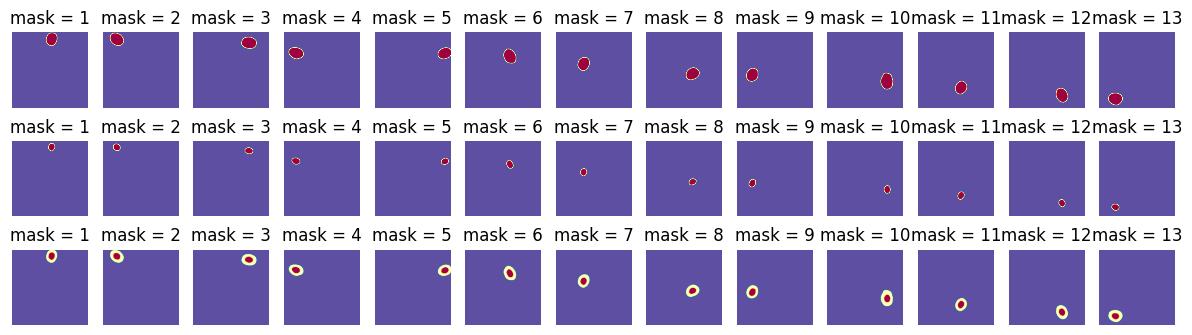

In [19]:
# Show the cytoplasms and corresponding nuclei
number_detected_cells = np.max(masks_cyto) # number of detected cells

fig, ax = plt.subplots(3,number_detected_cells, figsize=(15, 4)) # creates a figure with 3 rows and number_detected_cells columns
for i in range (1,number_detected_cells+1): # loops through each detected cell
  selected_cyto_mask = masks_cyto==i # finds the mask of the cytosol
  ax[0,i-1].imshow(selected_cyto_mask,cmap='Spectral_r') # plots the mask of the cytosol
  ax[0,i-1].set(title='mask = ' + str(i) ) # sets the title of the plot
  ax[0,i-1].axis('off') # turns off the axis

  # find which nucleus is associated with the cytosol
  selected_nuc_mask = masks_nuc==nucleus_indices[i] # finds the mask of the nucleus
  ax[1,i-1].imshow(selected_nuc_mask,cmap='Spectral_r') # plots the mask of the nucleus
  ax[1,i-1].set(title='mask = ' + str(i) ) # ses the title of the plot
  ax[1,i-1].axis('off') # turns off the axis

  # find which nucleus is associated with the cytosol
  combined = selected_nuc_mask.astype(int) + selected_cyto_mask.astype(int) # combines the masks
  ax[2,i-1].imshow(combined,cmap='Spectral_r') # plots the combined mask
  ax[2,i-1].set(title='mask = ' + str(i) ) # sets the title of the plot
  ax[2,i-1].axis('off') # turns off the axis
plt.show()

# Area and Intensity Calculations

## Cytoplasm and Nuclei Areas

In [22]:
# Make a list of their areas.
list_cyt_areas = [] # list to store the areas of the cytoplasms
list_nuc_areas = [] # list to store the areas of the nuclei

for i in range (1,number_detected_cells+1): # loops through each detected cell
  selected_cyto_mask = masks_cyto==i # finds the mask of the cytosol
  area_cyto = np.sum(selected_cyto_mask) # calculates the area of the cytosol
  list_cyt_areas.append(area_cyto) # appends the area of the cytosol to the list
  selected_nuc_mask = masks_nuc==nucleus_indices[i] # finds the mask of the nucleus
  area_nuc = np.sum(selected_nuc_mask) # calculates the area of the nucleus
  list_nuc_areas.append(area_nuc) # appends the area of the nucleus to the list
  
print(list_cyt_areas, list_nuc_areas) # prints the areas of the cytoplasms and nuclei

[8158, 9572, 9944, 9393, 8561, 9947, 8824, 8986, 8879, 11206, 8366, 9313, 9641] [2748, 2769, 2830, 2971, 2655, 2959, 2636, 2568, 2941, 2756, 2730, 2665, 2698]


## Mean Intensities of Each Cell

In [21]:
# computing the mean intensity for each cell in the image.

list_mean_intensities = [] # list to store the mean intensities of the cells
for iMask in range (1, number_detected_cells+1): # loops through each detected cell
  selected_mask = (masks_cyto==iMask) # selects the mask of the cell
  selected_color_image = selected_mask*img_cyto # selects the color image of the cell
  list_mean_intensities.append(selected_color_image[np.nonzero(selected_color_image)].mean()) # appends the mean intensity of the cell to the list

# Converts the list to a pandas dataframe and displays it
df = pd.DataFrame(list_mean_intensities, columns=['protein intensity']) # converts the list to a pandas dataframe
df # displays the dataframe

,protein intensity
0,81.343834
1,63.891245
2,121.761062
3,88.646652
4,109.587548
5,117.721524
6,66.981981
7,81.629312
8,77.287532
9,124.436820
